In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from joblib import Parallel, delayed

In [27]:
# Setting matplotlib style
style.use('ggplot')

In [5]:
state = pd.read_csv('./data/IL_full.csv')

In [6]:
state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226922 entries, 0 to 226921
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   username        226922 non-null  object 
 1   to              103370 non-null  object 
 2   text            226922 non-null  object 
 3   retweets        226922 non-null  int64  
 4   favorites       226922 non-null  int64  
 5   replies         226922 non-null  int64  
 6   id              226922 non-null  int64  
 7   permalink       226922 non-null  object 
 8   author_id       226922 non-null  int64  
 9   date            226922 non-null  object 
 10  formatted_date  226922 non-null  object 
 11  hashtags        35225 non-null   object 
 12  mentions        31468 non-null   object 
 13  geo             0 non-null       float64
 14  urls            53275 non-null   object 
 15  city            226922 non-null  object 
 16  query           226922 non-null  object 
 17  date_range

In [7]:
state.groupby('city').count()['id']

city
aurora             530
bloomington        831
blue island      56367
bolingbrook       2875
bristol           3516
carbondale         595
champaign         1853
chicago          67125
danville            76
decatur            442
dixon              211
elgin             8010
enfield             10
fairfield           15
farmington          51
fox lake          3676
freeport           102
galena              21
gurnee            5666
harrisburg          93
hecker             440
highland park     9511
jacksonville        81
kewanee             38
macomb             209
marengo           1242
marion             763
marissa            111
marshall            18
melvin              42
monmouth           252
mt carmel           13
naperville        2581
nokomis             60
oblong              36
onarga              28
orland park      47329
paris                9
paw paw             21
peoria            1294
rockford          1651
round lake        5744
san jose            41
spring

In [12]:
state_df = state.copy()[['username', 'text', 'date', 'city', 'state', 'month', 'day']]

In [36]:
state_df['date'] = pd.to_datetime(state_df['date'], utc=True)

In [44]:
# Creating year month day column because we'll need a way to sort dates across months
state_df['year_month_day'] = state_df['date'].dt.date

In [45]:
state_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226922 entries, 0 to 226921
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   username        226922 non-null  object             
 1   text            226922 non-null  object             
 2   date            226922 non-null  datetime64[ns, UTC]
 3   city            226922 non-null  object             
 4   state           226922 non-null  object             
 5   month           226922 non-null  int64              
 6   day             226922 non-null  int64              
 7   year_month_day  226922 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(2), object(5)
memory usage: 13.9+ MB


In [52]:
state_df['year_month_day'].sort_values()

226921    2020-03-17
67682     2020-03-17
67681     2020-03-17
67680     2020-03-17
67679     2020-03-17
             ...    
72365     2020-03-30
72364     2020-03-30
72363     2020-03-30
72375     2020-03-30
0         2020-03-30
Name: year_month_day, Length: 226922, dtype: object

In [46]:
state_df.groupby('year_month_day').count()

,username,text,date,city,state,month,day
year_month_day,,,,,,,
2020-03-17,21119,21119,21119,21119,21119,21119,21119
2020-03-18,17020,17020,17020,17020,17020,17020,17020
2020-03-19,19434,19434,19434,19434,19434,19434,19434
2020-03-20,15464,15464,15464,15464,15464,15464,15464
2020-03-21,16861,16861,16861,16861,16861,16861,16861
2020-03-22,16578,16578,16578,16578,16578,16578,16578
2020-03-23,14146,14146,14146,14146,14146,14146,14146
2020-03-24,16663,16663,16663,16663,16663,16663,16663
2020-03-25,15397,15397,15397,15397,15397,15397,15397


In [121]:
def plot_tweets_per_day(data):
    x = sorted(data['year_month_day'].value_counts().index) # Sorted dates
    y = data.groupby('year_month_day').count()['username'] # Num tweets per day

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x, y, s=50, marker='o', color='darkred', zorder=3)
    sns.lineplot(x, y, color='red', linewidth=2.2)
    plt.axvline(x[3], color='blue') # 3rd day of search is the announcement date
    plt.title(f'Tweets per day in {data["state"][0]} surrounding Covid announcement date')
    plt.ylabel('Number of Tweets')
    plt.legend(labels=['_', 'Date shut-down announced'])
    plt.xlabel('Date');

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:11: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001E99C74D088> has a label of '_' which cannot be automatically added to the legend.
  # This is added back by InteractiveShellApp.init_path()


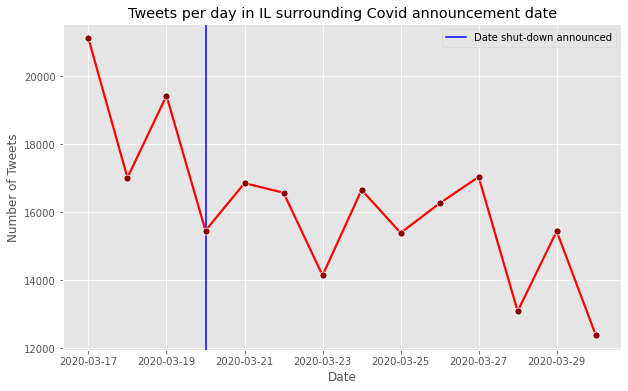

In [122]:
plot_tweets_per_day(state_df)

Tweet activity steadily decreased in the weeks following the announcement of the shut-down in Illinois on **March 20, 2020**

In [171]:
top_tweeting_cities.index

Index(['bolingbrook', 'bristol', 'fox lake', 'gurnee', 'round lake', 'elgin',
       'highland park', 'orland park', 'blue island', 'chicago'],
      dtype='object', name='city')

In [266]:
def plot_top_and_bottom_tweeting_cities(data):
    top_tweeting_cities = data.groupby('city').count()['username'].sort_values().tail(10)
    bottom_tweeting_cities = data.groupby('city').count()['username'].sort_values().head(10)
    
    fig, ax = plt.subplots(nrows=2, figsize=(10, 12))
    
    top_tweeting_cities.plot(kind='barh',
                         x=top_tweeting_cities.index,
                         y=top_tweeting_cities.values,
                         ax=ax[0],
                         color='darkred')

    ax[0].set_title(f'Top 10 Tweeting Cities in {data["state"][0]}', size=20, pad=15)
    ax[0].set_ylabel('City Name', size=16)
    ax[0].set_xlabel('Number of Tweets', size=16)
    ax[0].set_yticklabels([label.title() for label in top_tweeting_cities.index], # Setting city name to capital letters
               fontsize=12);
    
    bottom_tweeting_cities.plot(kind='barh',
                     x=bottom_tweeting_cities.index,
                     y=bottom_tweeting_cities.values,
                     ax=ax[1],
                     color='darkblue')

    ax[1].set_title(f'Bottom 10 Tweeting Cities in {data["state"][0]}', size=20, pad=15)
    ax[1].set_ylabel('City Name', size=16)
    ax[1].set_xlabel('Number of Tweets', size=16)
    ax[1].set_yticklabels([label.title() for label in bottom_tweeting_cities.index], # Setting city name to capital letters
               fontsize=12)
    plt.tight_layout();

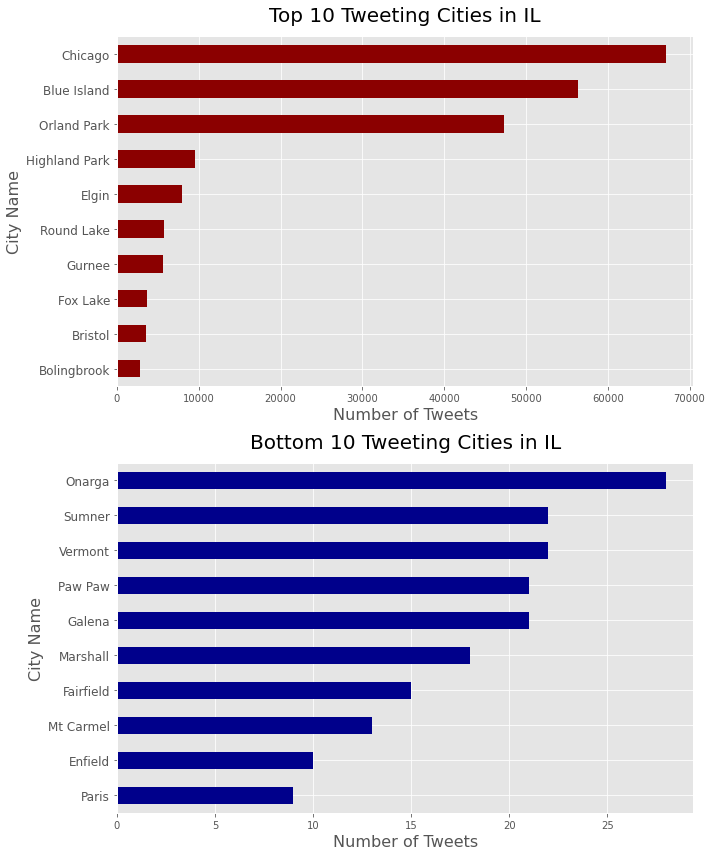

In [267]:
plot_top_and_bottom_tweeting_cities(state_df)

**Note the drastic difference in scale!** The top three tweeting regions are Chicago, Blue Island, and Orland Park. Note that these may not be precise city areas, but regions, as our collection method involved the radius surrounding a city.

In [ ]:
city_tweets_per_day = state_df.groupby(['city', 'year_month_day']).count()[['username']]

In [370]:
city_tweets_per_day.T['chicago'].T.index

Index([2020-03-17, 2020-03-18, 2020-03-19, 2020-03-20, 2020-03-21, 2020-03-22,
       2020-03-23, 2020-03-24, 2020-03-25, 2020-03-26, 2020-03-27, 2020-03-28,
       2020-03-29, 2020-03-30],
      dtype='object', name='year_month_day')

In [387]:
def plot_city_tweets_per_day(data, city):
    '''
    Need to have "state_df" defined
    '''
    sort_dates = sorted(data['year_month_day'].value_counts().index) # Sorted dates
    city_tweets_per_day = data.groupby(['city', 'year_month_day']).count()[['username']]
    city_tweets_per_day.T[city].T.plot(figsize=(10, 6), linewidth=2.2, marker='o')
    plt.title(f'Tweets Over Time in {city.title()}')
    plt.axvline(sort_dates[3], color='darkblue')
    plt.legend(['_', 'Date of shutdown announcement']);

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001EA53EF5208> has a label of '_' which cannot be automatically added to the legend.
  # Remove the CWD from sys.path while we load stuff.


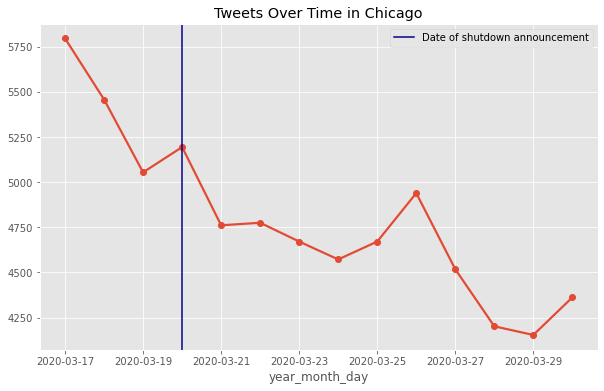

In [396]:
plot_city_tweets_per_day(state_df, 'chicago')

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001EA53682048> has a label of '_' which cannot be automatically added to the legend.
  # Remove the CWD from sys.path while we load stuff.


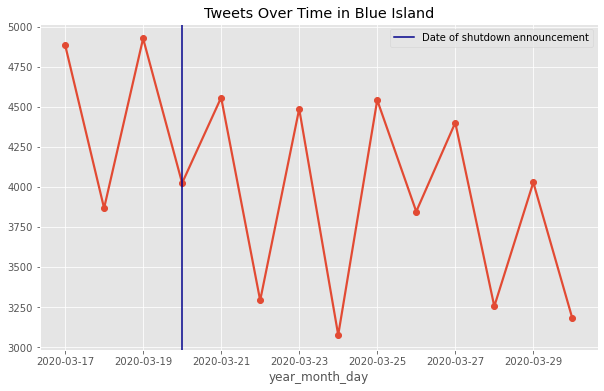

In [400]:
plot_city_tweets_per_day(state_df, 'blue island')

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001EA53EDB3C8> has a label of '_' which cannot be automatically added to the legend.
  # Remove the CWD from sys.path while we load stuff.


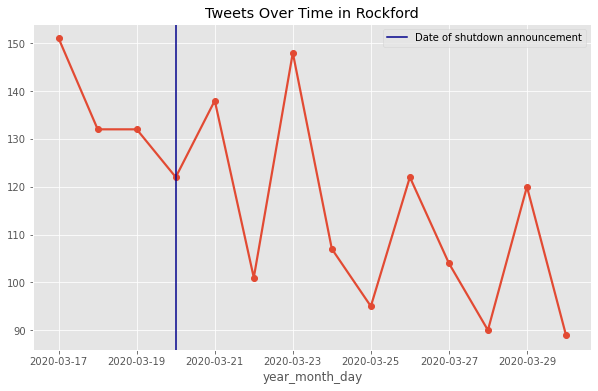

In [398]:
plot_city_tweets_per_day(state_df, 'rockford')

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001EA53EFBD08> has a label of '_' which cannot be automatically added to the legend.
  # Remove the CWD from sys.path while we load stuff.


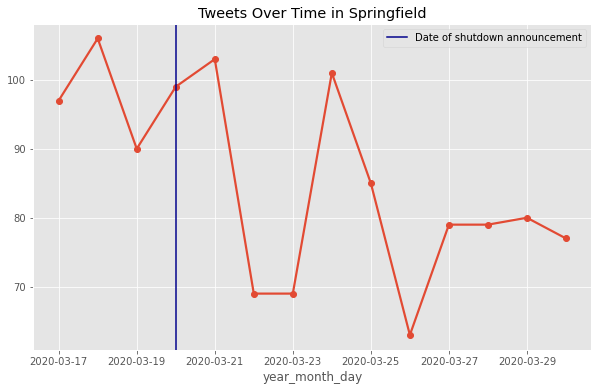

In [393]:
plot_city_tweets_per_day(state_df, 'springfield')

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001EA5373A0C8> has a label of '_' which cannot be automatically added to the legend.
  # Remove the CWD from sys.path while we load stuff.


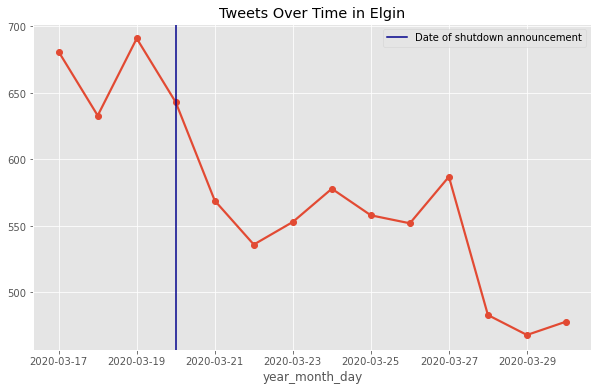

In [394]:
plot_city_tweets_per_day(state_df, 'elgin')

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001EA53436288> has a label of '_' which cannot be automatically added to the legend.
  # Remove the CWD from sys.path while we load stuff.


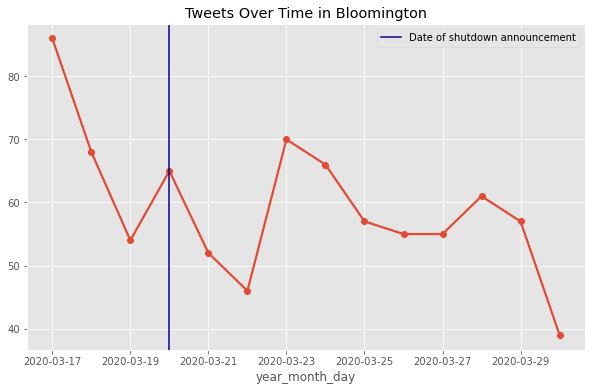

In [399]:
plot_city_tweets_per_day(state_df, 'bloomington')

In [24]:
stop_words = ['http', 'https', 'igshid', 'becau']

In [25]:
def tokenize_and_stem(text, stemmer=True):
    '''
    This does more than just tokenize and stem! The code removes links and
    html artifacts and is great for dirty data scraped from Reddit.
    
    Needs to be run within a loop to work properly.
    '''
    # Getting rid of links
    text = [word for word in text.lower().split() if not 'http' in word]

    text = ' '.join(text)
    
    # Remove HTML Artifacts
    bs = BeautifulSoup(text)
    text = bs.get_text()
    
    # Tokenize clean text by separating out all word characters
    tokenizer = RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(text)
    
    # Stem the tokens
    p_stemmer = PorterStemmer()
    return [p_stemmer.stem(i) for i in tokens]

def tokenize(text):
    # Getting rid of links
    text = [word for word in text.lower().split() if not 'http' in word]
    
    text = ' '.join(text)
    
    # Remove HTML Artifacts
    bs = BeautifulSoup(text)
    text = bs.get_text()
    
    # Tokenize clean text by separating out all word characters
    tokenizer = RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(text)
    return tokens

In [26]:
custom_sw = stopwords.words('english') + stop_words
processed_sw = tokenize_and_stem(' '.join(custom_sw))

In [35]:
cvec_processed_sw = tokenize(' '.join(custom_sw))

cvec = CountVectorizer(stop_words=custom_sw, tokenizer=tokenize)
cvec_fit = cvec.fit(state_df['text'])
cvec_transform = cvec.transform(state_df['text'])

cvec_df = pd.DataFrame(cvec_transform.todense(),
                 columns=cvec_fit.get_feature_names())

cvec_df.head()

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\bs4\__init__.py:333: MarkupResemblesLocatorWarning: "......." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\bs4\__init__.py:333: MarkupResemblesLocatorWarning: ".." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\bs4\__init__.py:333: MarkupResemblesLocatorWarning: "..." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupRe

,0,00,000,00000,000000,000069,000th,001,002,00am,...,잡힐거같은,제발,준비가,진짜,한여름,해볼,해요,ﾉ,𝕔𝕠𝕣𝕣𝕖𝕔𝕥𝕠,𝕝𝕠
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
top_words_cvec = {}
for column in tqdm(cvec_df.columns):
    top_words_cvec[column] = cvec_df[column].sum()

most_freq_cvec = pd.DataFrame(sorted(top_words_cvec.items(), key = lambda x: x[1], reverse=True))

100%|██████████| 43125/43125 [00:49<00:00, 868.41it/s] 


In [47]:
most_freq_cvec.to_csv('./data/top_words_cvec.csv', index=False)

In [50]:
most_freq_cvec.head(200)[0].tolist()

['like',
 'get',
 'one',
 'time',
 'people',
 'day',
 'know',
 'good',
 'love',
 'today',
 'illinois',
 'need',
 'go',
 'would',
 'got',
 'home',
 'us',
 '2',
 'right',
 'going',
 'great',
 'work',
 'see',
 'thank',
 'back',
 'think',
 'still',
 'really',
 '3',
 '1',
 'want',
 'even',
 'make',
 'well',
 'much',
 'please',
 'let',
 'trump',
 'way',
 'stay',
 'new',
 'lol',
 'never',
 'quarantine',
 'take',
 'best',
 'thanks',
 'could',
 'shit',
 'first',
 '4',
 'better',
 'yes',
 '5',
 'help',
 'everyone',
 'year',
 'last',
 'man',
 'happy',
 'coronavirus',
 'keep',
 'il',
 'say',
 'life',
 'said',
 'every',
 'ever',
 'family',
 'many',
 'virus',
 'also',
 'hope',
 '6',
 'always',
 'feel',
 'thing',
 'getting',
 'made',
 'look',
 'god',
 'week',
 'things',
 'world',
 'sure',
 'u',
 'game',
 'come',
 'stop',
 '7',
 'school',
 'done',
 'years',
 'days',
 'live',
 'watch',
 'bad',
 'care',
 'miss',
 'little',
 'next',
 'show',
 'times',
 'working',
 '10',
 'house',
 'put',
 'social',
 'two